In [ ]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import numpy as np
import scipy as sp
from numpy.random import rand
import matplotlib.pyplot as plt
import time
import scipy.linalg as la
from math import prod
from functools import lru_cache


In [11]:
a=4.0232/2

N=1
s=1
m=1
A=1
J=N*m
MHz = 1e6
kHz = 1e3
us = 1e-6
T = N/(A*m)
mu0 = 4*np.pi*1e-7 * (N/A**2)
hbar = 1.054571817 * 1e-34 * (J*s)
gammaF = 2*np.pi * 40.078 * (MHz/T) # spin 1/2
gammaE = 2*np.pi * 28024.9514242 * (MHz/T) # spin 1/2 
gammaLi = 2*np.pi * 16.546 * (MHz/T) # spin 3/2

# coupling strengths in Hz * A**3
Jf = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaF**2 * (10**10)**3
Jlif = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaLi*gammaF * (10**10)**3

In [22]:
r0 = 2

n_f_atoms =4*r0**3+6*r0**2+3*r0+1
n_li_atoms = n_f_atoms-1

odds=list(range(-r0,r0+1,2))
evens=list(range(-r0+1,r0+1,2))
def flatten(xsss):
    return [x for xss in xsss for xs in xss for x in xs]

def f_coupling_3d(posi, posj, B=(0,0,1)):
    #
    # compute the coupling matrix element of two fluorine spins
    # relative to a large external B field, in a 3d lattice
    #
    if posi == posj:
        return 0
    if type(posi) is int:
        posi = f_atom_pos[posi]
    if type(posj) is int:
        posj = f_atom_pos[posj]
        
    r = (np.array(posi)-np.array(posj))
    d = la.norm(r)
    if d < 1e-8:
        return 0

    bdir = np.array(B) / la.norm(np.array(B))
    cos = (r @ bdir) / d
    return Jf * (1-3*cos**2) / d**3


f_atom_pos = flatten([[[np.array([i*a,j*a,k*a]) for i in odds] for j in odds] for k in odds]) + flatten([[[np.array([i*a,j*a,k*a]) for i in evens] for j in evens] for k in odds])
f_atom_pos += flatten([[[np.array([i*a,j*a,k*a]) for i in evens] for j in odds] for k in evens]) + flatten([[[np.array([i*a,j*a,k*a]) for i in odds] for j in evens] for k in evens])

In [ ]:
dense_grids = {}

def grid_graph(dim):
    r"""
    Generate a dense graph of dimension len(dim) with side lengths
    define by the tuple `dim`
    
    This graphs are not labeled with spatial coordinates
    """
    if len(dim) == 1:
        return rx.generators.path_graph(dim[0])
    elif len(dim) == 2:
        return rx.generators.path_graph(dim[0],dim[1])
    else:
        G=rx.generators.path_graph(dim[0])
        for idx in range(1,len(dim)):
            Gnew=rx.generators.path_graph(dim[idx])
            G, _ = rx.cartesian_product(Gnew,G)
        return G
    

def generate_percolation_graph(p,dim):
    r"""
    generate a percolation graph with bond acceptance probability p
    `dim` should be a tuple containing the dimension of the graph,
    e.g (L,) or (L,L)
    """
    if dim in dense_grids:
        G = dense_grids[dim].copy()
    else:
        G = grid_graph(dim)
        dense_grids[dim] = G.copy()
    
    temp = [edge if p < rand() else -1 for edge in G.edge_list()]
    remove_list = [x for x in temp if x != -1] if -1 in temp else temp
    G.remove_edges_from(remove_list)
    return G

def avg_cluster_size(p, dim, repititions=100):
    r"""
    For a square graph of L*L nodes, compute the average cluster size,
    excluding the largest cluster. As L->infinity, this ensures that this
    function diverges at the phase transition, but nowhere else.
    """
    sites=prod(dim)
    counts = np.zeros(sites+1,dtype=np.int64)
    for _ in range(repititions):
        G = generate_percolation_graph(p,dim)
        comps = rx.connected_components(G)
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        temp_counts = np.bincount([len(comp) for comp in comps],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts)

def percolation_strength(p,dim,repititions=100):
    r"""
    For a square graph of L*L nodes, compute the percolation strength,
    which is the proportion of the graph belonging to the largest cluster,
    which should be the order paramater of the phase tranistion as L->infinity
    """
    P = 0
    sites = prod(dim)
    for _ in range(repititions):
        G = generate_percolation_graph(p,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
    return P/repititions

def cluster_size_and_strength(p,dim,repititions=100):
    r"""
    return both the percolation strength and the average cluster size
    for the square L*L percolation graph as a tuple (size, strength)
    """
    sites = prod(dim)
    counts = np.zeros(sites+1,dtype=np.int64)
    P = 0
    for _ in range(repititions):
        G = generate_percolation_graph(p,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
        temp_counts = np.bincount([len(comp) for comp in rx.connected_components(G)],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts), P

In [ ]:
nn_adjacency = [np.array([alpha*a, beta*a,0]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([alpha*a,0,beta*a]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([0,alpha*a,beta*a]) for alpha in (-1,1) for beta in (-1,1)]

def generate_fcc(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    odds=list(range(-r0,r0+1,2))
    evens=list(range(-r0+1,r0+1,2))
    f_atom_pos = flatten([[[np.array([i*a,j*a,k*a]) for i in odds] for j in odds] for k in odds]) + flatten([[[np.array([i*a,j*a,k*a]) for i in evens] for j in evens] for k in odds])
    f_atom_pos += flatten([[[np.array([i*a,j*a,k*a]) for i in evens] for j in odds] for k in evens]) + flatten([[[np.array([i*a,j*a,k*a]) for i in odds] for j in evens] for k in evens])
        
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,None)
                counter += 1
                if counter == len(nn_adjacency):
                    break
                
    return G

In [45]:
G=rx.PyGraph(multigraph=False)

In [46]:
node_indices = G.add_nodes_from(f_atom_pos)

In [47]:
nn_adjacency = [np.array([alpha*a, beta*a,0]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([alpha*a,0,beta*a]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([0,alpha*a,beta*a]) for alpha in (-1,1) for beta in (-1,1)]

In [62]:
for idxA in node_indices:
    source = G.get_node_data(idxA)
    counter=0
    for idxB in node_indices:
        target = G.get_node_data(idxB)
        if np.any(np.all(nn_adjacency == source-target, axis=1)):
            G.add_edge(idxA,idxB,None)
            counter += 1
            if counter == len(nn_adjacency):
                break

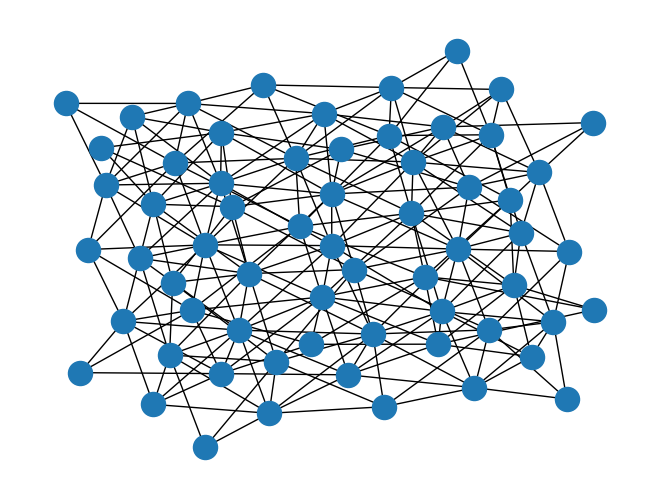

In [63]:
rx.visualization.mpl_draw(G)

In [51]:
G.edges()

[]

In [60]:
def grid_graph_2d(L):
    r"""
    Returns a 2d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b)
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L,i+1+j*L,None) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L,i+(j+1)*L,None) for j in range(L-1) for i in range(L)])
    return G

In [77]:
def grid_graph_3d(L):
    r"""
    Returns a 2d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b)
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j,k) for k in range(L) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i+1)+j*L+k*L**2,None) for k in range(L) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+(j+1)*L+k*L**2,None) for k in range(L) for j in range(L-1) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+j*L+(k+1)*L**2,None) for k in range(L-1) for j in range(L) for i in range(L)])
    return G

In [104]:
def grid_graph(L,dim=2):
    G=rx.generators.path_graph(L)
    Gnew=rx.generators.path_graph(L)
    for _ in range(dim-1):
        G, hold = rx.cartesian_product(Gnew,G)
    return G